# Test Network Dispersion differences 

from `https://github.com/biancaserio/sex_diff_ gradients` & `scripts/p1_main.ipynb` (at the very bottom, search for `dispersion`)

In [98]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
import pandas as pd

bids_folder = '/mnt_03/ds-dnumrisk' 

subList = [f[4:6] for f in os.listdir(bids_folder) if f[0:4] == 'sub-' and len(f) == 6]

# add group info
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')
group_list = group_list#.reset_index()


In [78]:
# I need a mapping of Glasser parcellation to Yeo networks

import numpy as np
from scipy.stats import mode

# glasser_parcellation: 1D numpy array with Glasser labels (360 unique labels, same length as fsaverage5 surface)
from utils import get_glasser_parcels
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )
glasser_parcellation = labeling_glasser
unique_glasser_labels =np.setdiff1d(glasser_parcellation,[1000,2000])

# yeo_parcellation: 1D numpy array with Yeo network labels (17 unique labels, same length as fsaverage5 surface)
from brainstat.datasets import fetch_parcellation
yeo_atlas_fsav5 = fetch_parcellation('fsaverage5', 'yeo',17)
yeo_parcellation = yeo_atlas_fsav5

# Initialize an array to hold the Yeo network assignment for each Glasser region
glasser_to_yeo_mapping = np.zeros(360, dtype=int)

# Loop over each unique Glasser region (1 to 360)
i=0
for i,region_label in enumerate(unique_glasser_labels) : #range(1, 361):
    # Get the indices of vertices that belong to this Glasser region
    indices_in_region = np.where(glasser_parcellation == region_label)[0]
    
    # Find the mode (most common Yeo label) among these vertices
    yeo_label = mode(yeo_parcellation[indices_in_region])[0]#[0]
    
    # Assign this Yeo label to the Glasser region in the mapping array
    glasser_to_yeo_mapping[i] = yeo_label
    
# The array `glasser_to_yeo_mapping` now holds the Yeo network label (1-17) for each Glasser region (1-360)
print(glasser_to_yeo_mapping)



[ 2  5  2  2  1  1  1  3  3  6 12 17  2 11 11  1  5  5  1  1  1  1  5  4
 14 17 11 14 11 16 15 16 16 16 16  3  7  7  3  3  7  6  7  7  6  5  6  5
  5  5  3  3  3  3  3  4  7  8  7  7 16 16 13 16 16 17 17 16 17 17 17 16
 13 17 17 17 13  7 12 12 12 12 12  8 13  8 17 10 13 10 10 10 10 17 12  6
 13 13  7  4  4  4  4  4  7  7  4  7  7  0  8  8  7  7  7  6  6  9 15  0
  2  9 14  4 14 15 15 14 14 17  9 17 13 17  9  5 12  5 14 14  5  2  5 12
 12  5  7  7 13 17 16  2  2  1 15  1  5  1  5  2 16 16  1 10 10 10  7  4
  8 16 13  9  4  4  4 17 17  7  8 16  2  5  2  2  1  1  1  3  3  6 12  7
  2 11 11  1  5  1  1  1  1  1  1  4  7 17 11 14 11 16 15 16 16 16 16  3
  7  7  3  3  3  6  7  7  6  5  6  5  5  5  3  3  3  3  3  4  7  8  7  7
 16 16 13 16 16 17 13 16 16 17 16 16 13  8 17 17 13 12 12 12 12 12 12  8
  8  8 17 10 13 10 10 10 10 17 12  6 13 13  4  4  4  4  4  4  7  7  4  7
  7  0  8  8  7  7  4  6  6  9  0  0  2  9 14  4 14 15 15 14 14 17  9 17
 13  9  9  5 12  5 14 14  5  2  5 12 12  5  7  7 13

## get Network parcellation

### Yeo
tried many things (nilearn.datasets, neuromaps.datasets.annotations, brainspace.datasets.load_parcellation, or the original source: https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Yeo2011_fcMRI_clustering; but this repository is huge!!!), 

--> easiest seems via brainstats

### but maybe try Cole-Anticevic (fits with Glasser parcellation)
What Bin did in his asymmetry paper... be constistens with parcelattion/networks across analysis (asym, dispersion etc.)

In [13]:
from brainstat.datasets import fetch_parcellation

yeo_atlas_fsav5 = fetch_parcellation('fsaverage5', 'yeo',17) # join - hemispheres seperately
print('shape' + str(np.shape(yeo_atlas_fsav5)))
np.unique(yeo_atlas_fsav5)

shape(20484,)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int32)

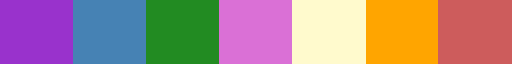

In [56]:
from matplotlib.colors import ListedColormap

# define custom colormap using color names (in order of corresponding networks: 1 visual, 2 sensorimotor, 3 dorsal attention, 4 ventral attention, 5 limbic, 6 fronto parietal, 7 DMN)
colors_yeo7 = ['darkorchid', 'steelblue', 'forestgreen', 'orchid', 'lemonchiffon', 'orange',  'indianred']
yeo7_colormap = ListedColormap(colors_yeo7, 'custom_colormap')
yeo7_colormap

In [95]:
# labels: 1=visual, 2=sensory motor, 3=dorsal attention, 4=ventral attention, 5=limbic, 6=fronto parietal, 7= DMN
datadir = '/mnt_03/diverse_neuralData/atlases_parcellations'

yeo7_networks_names = pd.read_csv(op.join(datadir,'17NetworksOrderedNames.csv'))
yeo7_networks_names

,Network Order,Network Name
0,1,Visual Central (Visual A)
1,2,Visual Peripheral (Visual B)
2,3,Somatomotor A
3,4,Somatomotor B
4,5,Dorsal Attention A
5,6,Dorsal Attention B
6,7,Salience / Ventral Attention A
7,8,Salience / Ventral Attention B
8,9,Limbic A
9,10,Limbic B


In [79]:
# gradient values, parcel x subject
#g1 = hemi_array_aligned_fc_G1.T  # transpose to obtain shape (400 x 1000) in order to access/index the relevant network nodes

n_grad =1
gms_aligned = [None] * len(subList)

for i, sub in enumerate(subList):
    source_folder_gm = op.join(bids_folder,'derivatives','gradients',f'sub-{sub}' )
    #gm = np.load(op.join(source_folder_gm,f'sub-{sub}_gradients_glasserParcel.npy')) # save all together
    gm_aligned = np.load(op.join(source_folder_gm,f'sub-{sub}_g-aligned_glasserParcel.npy'))
    gms_aligned[i] = gm_aligned[:,n_grad-1] # only one grad to start with

# to create multidimensional array with all subs, grads & parcels, look at asym_grad....
sub_array= np.array([int(i) for i in subList]) 
n_parcels = np.shape(gms_aligned)[1] # 180

df = pd.DataFrame(np.array(gms_aligned), index=sub_array)
df.columns = [f"parcel_{i+1}" for i in range(n_parcels)]


In [112]:
# compute for each subject and for each yeo network a) network centroid position; b) within network dispersion metric (higher value = wider distribution = more dispersion)

yeo_cog = []  # center of gravity (median) for given network (i.e., network centroid position) (7 x 1000)
WN_dispersion = []  # Within network dispersion: sum squared Euclidean distance of network nodes to the network centroid at individual level (7 x 1000)


# gradient values
g1 = np.array(gms_aligned).T  # transpose to obtain shape (360 x 66) in order to access/index the relevant network nodes

# iterate over the 7 Yeo networks
for n in range(17):
    
    # identify the nodes of given Yeo network
    netNodes = np.where(glasser_to_yeo_mapping == (n + 1))
    netNodes = np.squeeze(netNodes)
    
    # get the gradient loadings of the nodes of the given Yeo network, for each subject (shape: number of nodes in network x N)
    G1_net = g1[netNodes]
    
    ### identify the centroid / center of gravity (= median) of the given Yeo network for each subject (shape: N)
    yeo_cog_net = np.median(G1_net, axis=0)  
    yeo_cog.append(yeo_cog_net)
    
    ### within network dispersion: 1 within network dispersion value per subject (per network)
    
    # compute (per subject) the Eucledian distance between each gradient loading (in Yeo network) and that network's centroid
    dist_nodes_to_cog = G1_net - yeo_cog_net  # shape: number of nodes in network x N
    
    # take the sum of squares of this Eucledian distance 
    sum_of_squares = np.mean((dist_nodes_to_cog**2), axis = 0)  # shape: N # sum originally!!
    
    # append to list
    WN_dispersion.append(sum_of_squares)
    
    
yeo_cog = np.array(yeo_cog)
WN_dispersion = np.array(WN_dispersion)

In [113]:
sub_array

array([21, 59, 54, 15, 52,  8, 57, 50, 36, 56,  2, 22,  1, 19, 23,  6, 18,
       13,  3, 31, 55, 41, 65, 49, 29, 34, 17, 27, 30, 51, 20, 66, 24, 46,
       39, 47, 14, 37,  4, 61, 45, 26, 58, 33, 40, 64, 32, 11, 35, 16, 38,
       48, 63, 43, 10, 53,  5,  7,  9, 12, 62, 28, 42, 25, 44, 60])

In [114]:
df = pd.DataFrame(np.array(WN_dispersion.T), index=sub_array,columns = [f"yeo_{i+1}" for i in range(17)])
df.index.name = 'subject'
df = df.join(group_list).set_index('group',append=True)

In [125]:
df

,,yeo_1,yeo_2,yeo_3,yeo_4,yeo_5,yeo_6,yeo_7,yeo_8,yeo_9,yeo_10,yeo_11,yeo_12,yeo_13,yeo_14,yeo_15,yeo_16,yeo_17
subject,group,,,,,,,,,,,,,,,,,
21,0,5.711488,16.660910,7.434670,0.794958,34.975107,25.704309,1.815739,0.864166,6.114491,1.128457,38.403449,24.166780,0.592611,20.037637,15.673668,13.813132,4.832137
59,0,14.380083,5.250228,0.279899,4.164618,27.076694,5.840177,7.236486,2.887516,1.142795,0.494830,17.983861,42.458936,18.177449,34.572658,7.925859,55.349098,12.721866
54,0,4.127748,13.180043,0.379323,2.097671,34.202080,4.235903,0.823376,1.203790,1.566885,0.347138,5.011147,7.549323,4.421617,5.867702,15.387971,8.350731,6.950993
15,0,11.853168,16.069030,0.591556,0.839368,65.498908,6.633336,3.272881,0.412893,27.678875,0.711233,9.659070,18.703061,1.737162,24.563704,34.114184,3.774603,4.625362
52,0,9.306772,19.682152,0.320055,0.733863,26.036086,4.893330,1.802320,0.852490,1.966725,0.517759,4.085809,8.921871,5.527866,12.246165,3.900265,16.044022,2.838550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,0,17.613615,21.809277,1.275266,0.774112,32.884166,12.191955,1.091069,0.369885,0.162159,0.116480,25.113055,8.971533,4.766754,9.282031,5.002403,11.287785,2.901198
42,1,9.528896,26.834863,2.634037,0.585250,69.875189,5.582653,1.628554,3.644054,10.807708,0.703571,10.826301,27.126308,3.990812,6.798353,6.807889,0.452473,7.419414
25,1,2.655880,14.643757,1.781612,2.257254,55.344525,3.590569,3.571169,0.503051,0.212003,0.203611,3.295155,5.155905,1.560099,33.983802,51.612105,0.768742,4.087856


<Axes: xlabel='yeo_4', ylabel='Density'>

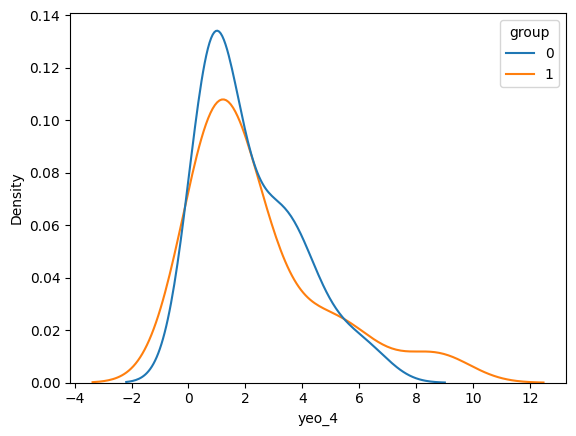

In [134]:
import seaborn as sns

tmp = df.loc[df.mean(axis=1) < 100]
sns.kdeplot(tmp.reset_index(), x='yeo_4',hue='group')

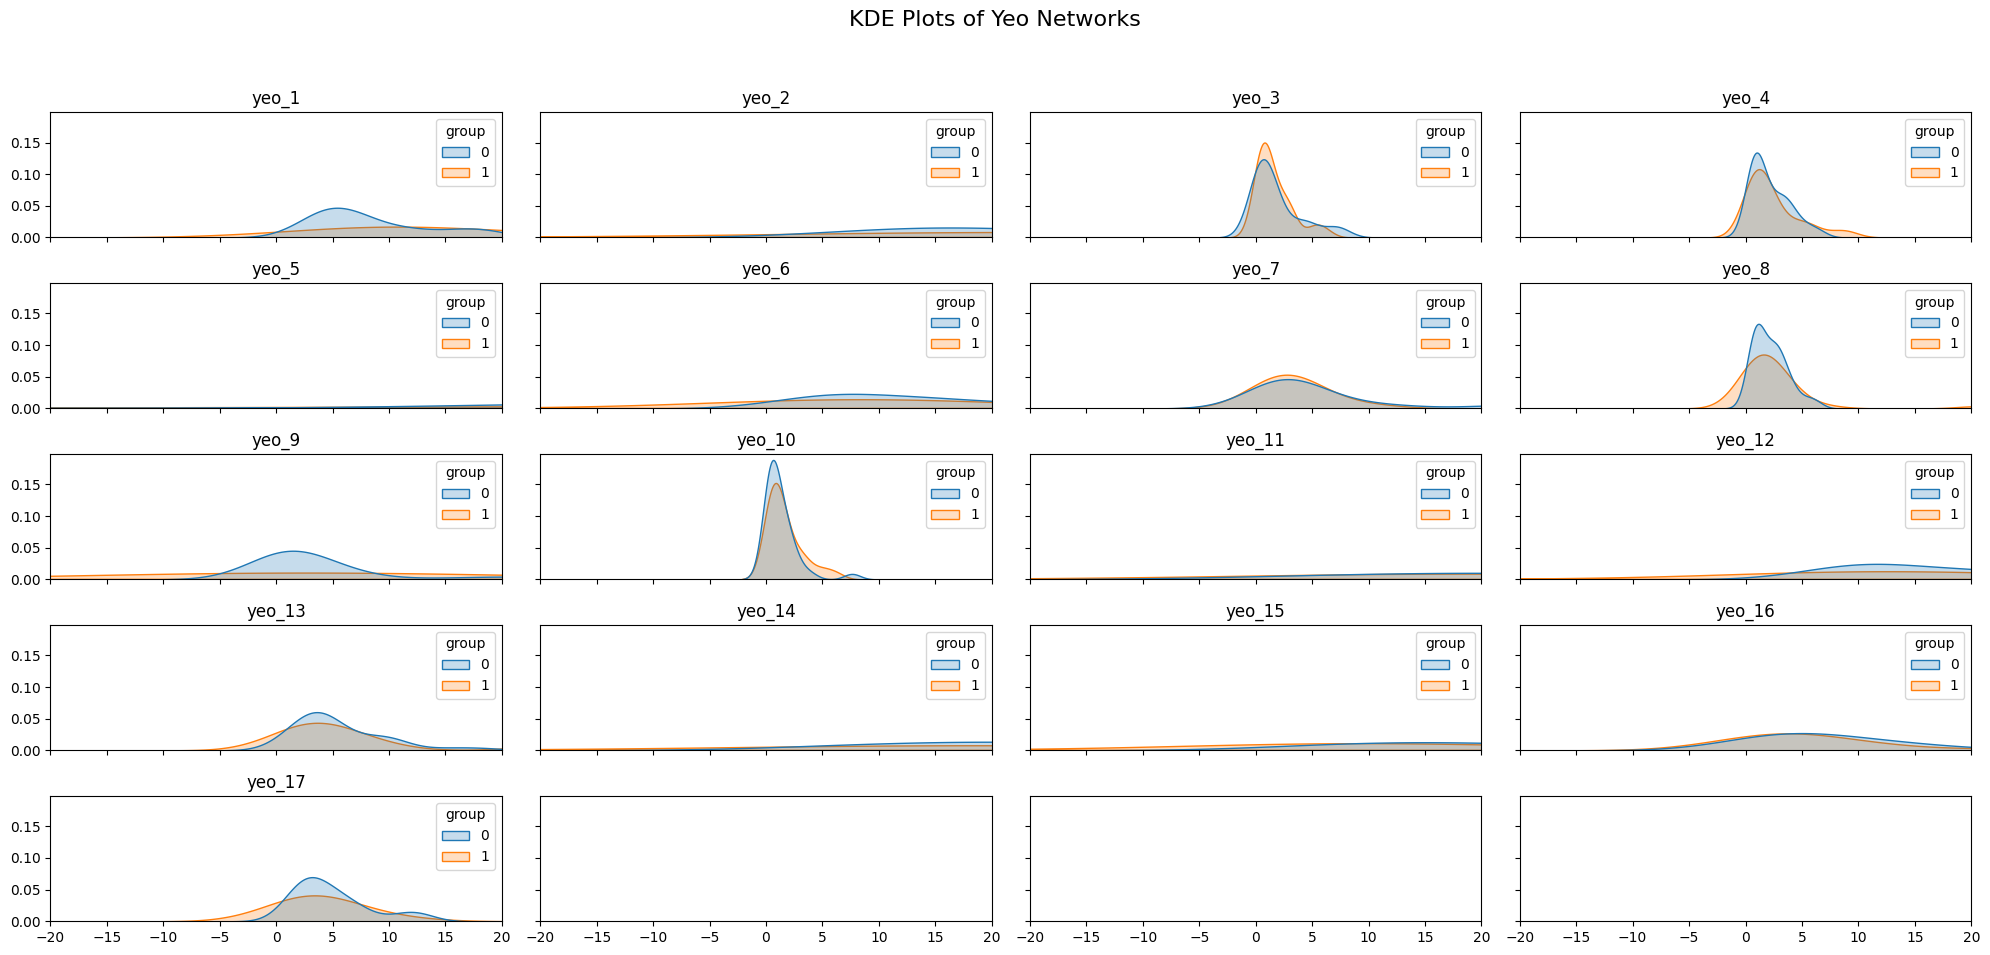

In [138]:
n_cols = 4  # Number of columns in the subplot grid
n_rows = (17 + n_cols - 1) // n_cols  # Calculate rows needed for 17 subplots

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10), sharex=True, sharey=True)
fig.suptitle('KDE Plots of Yeo Networks', fontsize=16)

for i in range(17):
    ax = axes[i // n_cols, i % n_cols]  # Calculate position in grid
    yeo_network = f'yeo_{i + 1}'
    
    # Plot KDE for each Yeo network with hue for 'group'
    sns.kdeplot(data=tmp, x=yeo_network, hue='group', ax=ax, fill=True)
    ax.set_title(yeo_network)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim(-20,20)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the suptitle
plt.show()

In [133]:
df.loc[df.mean(axis=1) > 100]

,,yeo_1,yeo_2,yeo_3,yeo_4,yeo_5,yeo_6,yeo_7,yeo_8,yeo_9,yeo_10,yeo_11,yeo_12,yeo_13,yeo_14,yeo_15,yeo_16,yeo_17
subject,group,,,,,,,,,,,,,,,,,
51,1,63406.876601,60471.092884,12427.711509,18577.884292,146081.982620,111633.152419,61364.936357,44067.447985,56284.695495,42155.008677,30935.323288,66580.645019,70685.501633,18018.617930,2553.353523,18086.706960,41415.356296
66,0,175.346222,255.635642,88.477741,234.330100,580.834946,243.601227,469.306877,244.279464,1083.929165,112.171380,65.597032,321.191974,224.362265,307.596249,102.220334,512.977862,441.832198
43,1,102195.802269,17175.931234,3885.775836,16939.660233,57063.156194,2234.502367,8490.589839,10115.866599,10069.172252,15312.236497,23371.024010,37915.064056,15631.608423,9310.262462,12796.464080,3909.609176,13671.802937


<Axes: ylabel='Density'>

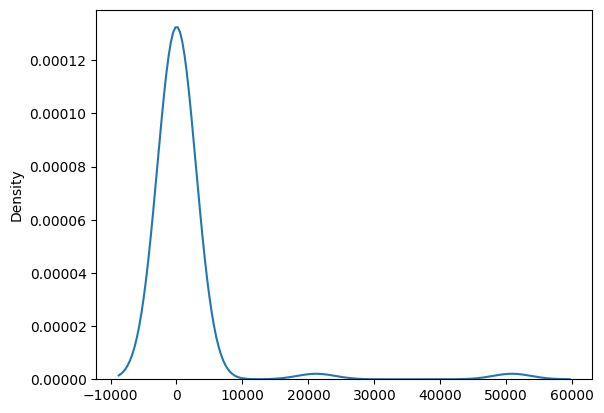

In [ ]:
sns.kdeplot(df.mean(axis=1)) # some outlier subjects

# old stuff

In [49]:
sub = '04'
n_grad=1
source_folder_gm = op.join(bids_folder,'derivatives','gradients',f'sub-{sub}' )
gm_aligned = np.load(op.join(source_folder_gm,f'sub-{sub}_g-aligned_glasserParcel.npy')).T#f'gradients_align-procrustes.npy'))

print(np.shape(gm_aligned))

from utils import get_glasser_parcels
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )

gm_fsav5 = map_to_labels(gm_aligned[n_grad-1], labeling_glasser, mask=mask_glasser, fill=np.nan) 

labeling_yeo = yeo_atlas_fsav5
mask_yeo = np.array([True]*len(labeling_yeo))

gm_yeo = reduce_by_labels(gm_fsav5, labeling_yeo, red_op= 'mode') # mode everything works except prenucues or something, with other more Nans

(10, 360)


In [50]:
gm_yeo

array([         nan, 130.71382482, 114.54589736,  42.40987184,
        42.40987184, 100.60750159,  50.15002527,  51.01508019,
        45.98574531,  35.84764995,  37.59699173,          nan,
        61.23922292,  46.2609199 ,  61.96379726,  49.26032509,
        43.4534635 ,  42.36104551])

In [51]:
pd.isna(gm_yeo).sum()

2

In [52]:
gm_yeo_ = map_to_labels(gm_yeo, labeling_yeo, mask=mask_yeo, fill=np.nan) 
np.shape(gm_yeo_)

(20484,)

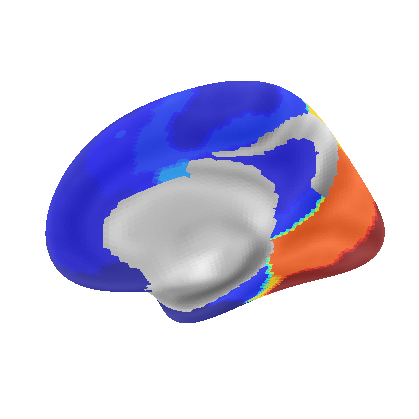

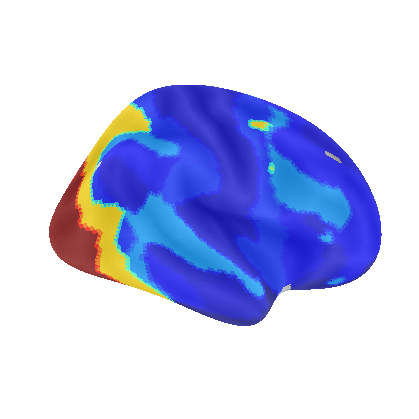

In [53]:
from  nilearn.datasets import fetch_surf_fsaverage
import nilearn.plotting as nplt
import nibabel as nib
import matplotlib.pyplot as plt

gm = np.split(gm_yeo_,2) # for i, hemi in enumerate(['L', 'R']): --> left first
gm_r = gm[1]

fsaverage = fetch_surf_fsaverage() # default 5
side_view = 'lateral'
cmap = 'jet'

nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= gm_r, # infl_right # pial_right
            view= side_view,cmap=cmap, colorbar=False, title=f'',
            bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7) #

plt.show()
nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= gm_r, # infl_right # pial_right
            view= 'medial',cmap=cmap, colorbar=False, title=f'',
            bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7) #

plt.show()

In [ ]:
# defining labeling scheme and mask
from brainspace.utils.parcellation import map_to_labels

labeling = load_parcellation('schaefer', scale=400, join=True)
#surf_lh, surf_rh = load_conte69()

mask = labeling != 0

networks = map_to_labels(yeo7_networks_array, labeling, mask=mask, fill=np.nan) 


2024-11-07 08:36:31,608 - brainstat - INFO - Downloading /tmp/tmpkpur8dhy.zip from https://box.bic.mni.mcgill.ca/s/vcSXEk1wx0jN86N/download.


array([3, 5, 3, ..., 9, 9, 9], dtype=int32)